In [ ]:
# Import
import pandas as pd
import numpy as np
import hvplot.pandas
import matplotlib.pyplot as plt
from pathlib import Path
from finta import TA
from talib import RSI, BBANDS

# Allow for reviewing more of the DataFrames
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)
pd.set_option('display.width', 1000)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import the fundamentals.csv file into a Pandas DataFrame
df_fundamentals_csv = pd.read_csv("Resources/fundamentals.csv", 
                                  infer_datetime_format=True,index_col="Date",
                                  parse_dates=True)

In [3]:
# To get rows between two dates
df_sliced = df_fundamentals_csv['2019':'2024']

In [4]:
# Create a column_names list of the desired columns
column_names = ['GOOGL Adj. Close', 'GOOGL P/S (LTM)', 'GOOGL P/FCF (LTM)',
       'GOOGL P/E (LTM)', 'GOOGL Debt/Equity (LTM)', 'NVDA Adj. Close',
       'NVDA P/S (LTM)', 'NVDA P/FCF (LTM)', 'NVDA P/E (LTM)',
       'NVDA Debt/Equity (LTM)', 'MMM Adj. Close', 'MMM P/S (LTM)',
       'MMM P/FCF (LTM)', 'MMM P/E (LTM)', 'MMM Debt/Equity (LTM)',
       'PG Adj. Close', 'PG P/S (LTM)', 'PG P/FCF (LTM)', 'PG P/E (LTM)',
       'PG Debt/Equity (LTM)']

# Copy the desired columns into a new DataFrame, df_final
df_final = df_sliced[column_names]

In [5]:
# Write cleaned DataFrame to a CSV file (includes null values related to balance sheet data)
df_final.to_csv('Resources/df_final.csv', index=True)

In [6]:
# Create separate DataFrames for each stock
googl_df = df_final[["GOOGL Adj. Close", "GOOGL P/S (LTM)","GOOGL P/FCF (LTM)","GOOGL P/E (LTM)","GOOGL Debt/Equity (LTM)"]]
nvda_df = df_final[["NVDA Adj. Close", "NVDA P/S (LTM)","NVDA P/FCF (LTM)","NVDA P/E (LTM)","NVDA Debt/Equity (LTM)"]]
mmm_df =  df_final[["MMM Adj. Close", "MMM P/S (LTM)","MMM P/FCF (LTM)","MMM P/E (LTM)","MMM Debt/Equity (LTM)"]]
pg_df = df_final[["PG Adj. Close", "PG P/S (LTM)","PG P/FCF (LTM)","PG P/E (LTM)","PG Debt/Equity (LTM)"]]

# Drop null values from each DataFrame's Adj. Close column (necessary for correct generation of SMAs, EMAs, BBands, and RSI)
googl_df.dropna(subset=["GOOGL Adj. Close"], inplace=True)
nvda_df.dropna(subset=["NVDA Adj. Close"], inplace=True)
mmm_df.dropna(subset=["MMM Adj. Close"], inplace=True)
pg_df.dropna(subset=["PG Adj. Close"], inplace=True)

In [7]:
# Create a list of individual stock DataFrame names and columns to feed loops
ticker_data = [(googl_df, "GOOGL Adj. Close"),(nvda_df, "NVDA Adj. Close"),(mmm_df, "MMM Adj. Close"),(pg_df, "PG Adj. Close")]

In [8]:
# Loop to add actual_returns column based on percentage change
for df_name, column_name in ticker_data:
    df_name["actual_returns"] = df_name[column_name].pct_change()

In [9]:
# Loop to Generate SMA and EMA columns
for df_name, column_name in ticker_data:
    df_name["sma_fast"] = df_name[column_name].rolling(window=10).mean()
    df_name["sma_slow"] = df_name[column_name].rolling(window=100).mean()
    df_name["ema_fast"] = df_name[column_name].ewm(span=10, adjust=False).mean()
    df_name["ema_slow"] = df_name[column_name].ewm(span=100, adjust=False).mean()

In [10]:
# Loop to Generate Bollinger Bands columns (manual generation)
for df_name, column_name in ticker_data:
    df_name["std_dev"] = df_name[column_name].rolling(window=20).std()
    df_name["bb_upper"] = df_name["sma_fast"] + (df_name["std_dev"] * 2)
    df_name["bb_lower"] = df_name["sma_fast"] - (df_name["std_dev"] * 2)

In [11]:
# Loop to Generate Bollinger Bands and RSI columns (alt. method using TA-Lib) and write to new columns in respective DataFrames
for df_name, column_name in ticker_data:
    up, mid, low = BBANDS(df_name[column_name], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df_name["RSI"] = RSI(df_name[column_name], timeperiod=14)
    df_name["bb_upper_talib"] = up
    df_name["bb_mid_talib"] = mid
    df_name["bb_lower_talib"] = low

#### Storing individual stock DataFrames with SMA, EMA, Bollinger Bands (manual method) and Bollinger Bands (TA-Lib method) to Resources folder

In [12]:
# Write individual stock DFs w/ SMA, EMA,  to CSV
googl_df.to_csv('Resources/googl_df.csv', index=True)
nvda_df.to_csv('Resources/nvda_df.csv', index=True)
mmm_df.to_csv('Resources/mmm_df.csv', index=True)
pg_df.to_csv('Resources/pg_df.csv', index=True)

#### Sample plots of Bollinger Bands (both methods) and RSI for GOOGL

In [13]:
# Plot Bollinger Bands for GOOGL (manual calculation) NOTE: the middle line for a Bollinger Band is typically an SMA
googl_df.hvplot.line(y=['GOOGL Adj. Close', 'bb_upper', 'sma_fast', 'bb_lower'], width=1000, height=400, title="GOOGL Bollinger Bands Method 1 - Manual Calculation")

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [14]:
# Plot Bollinger Bands for GOOGL (alternative method using TA-Lib)
googl_df.hvplot.line(y=['GOOGL Adj. Close', 'bb_upper_talib', 'bb_mid_talib', 'bb_lower_talib'], width=1000, height=400, title="GOOGL Bollinger Bands Method 2 - TA-Lib")

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

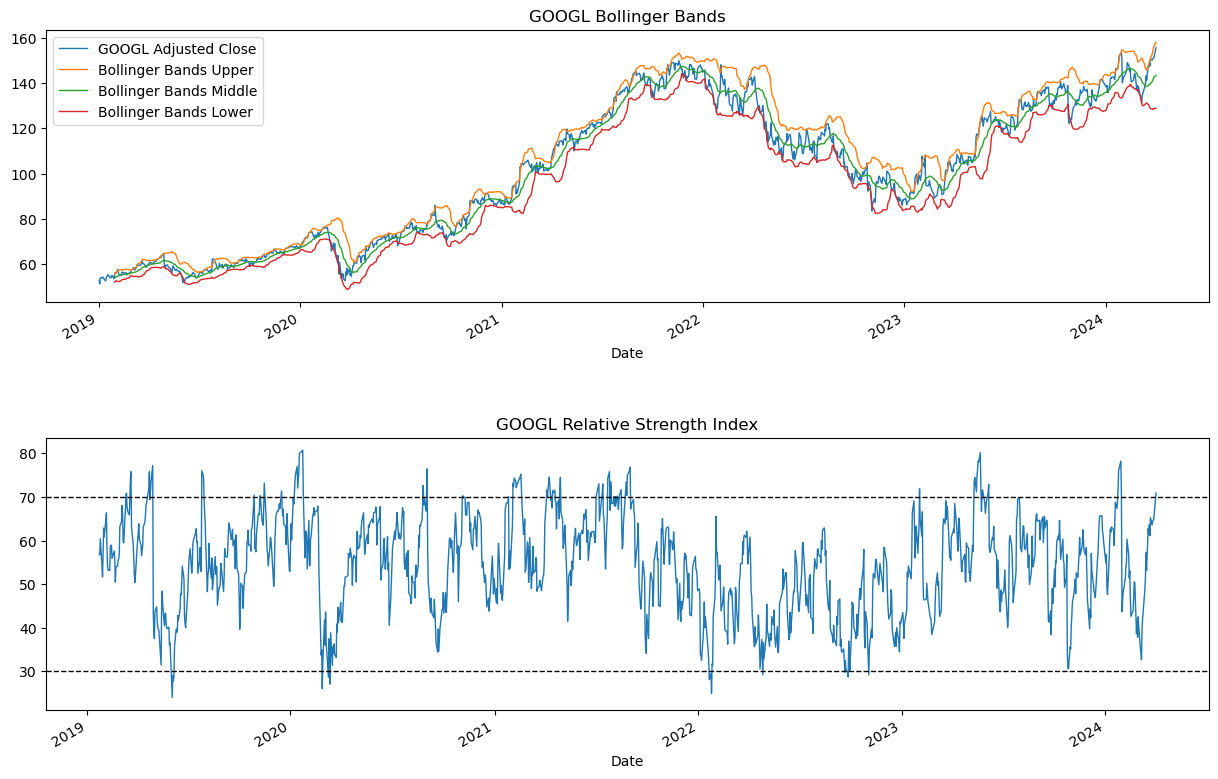

In [15]:
# Plot 2 subplots: Bollinger Bands and RSI (matplotlib)
figure, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
googl_df[['GOOGL Adj. Close', 'bb_upper_talib', 'bb_mid_talib', 'bb_lower_talib']].plot(ax=axes[0], lw=1, title='GOOGL Bollinger Bands')
googl_df['RSI'].plot(ax=axes[1], lw=1, title='GOOGL Relative Strength Index')
axes[0].legend(['GOOGL Adjusted Close', 'Bollinger Bands Upper', 'Bollinger Bands Middle', 'Bollinger Bands Lower'])
axes[1].axhline(70, lw=1, color='k', linestyle='--', label='Overbought (70)')
axes[1].axhline(30, lw=1, color='k', linestyle='--', label='Oversold (30)')
figure.subplots_adjust(hspace=0.5)
plt.show()